In [2]:
from urllib.request import urlopen, Request
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer
from urllib.request import urlopen
from matplotlib import pyplot as plt
import math
import datetime
from time import sleep
import copy
import json
import sys
import csv
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr   
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.utils import shuffle
from statsmodels.stats.stattools import durbin_watson

In [116]:
def AutocorrelationTest(array):
    return durbin_watson(array)

def ReduceDates(dates):
    count = 0
    for date in dates:
        if count%5 != 0:
            dates[count] = ' '
        count += 1
    return dates        

def PlotColumn(df, columns, scaler = StandardScaler(), title=None, ylabel = None, xlabel = None):
    
    #color=np.random.rand(3,), label=column
    
    dff = df[columns].copy()
    dff['date'] = df['date']
    ax = plt.gca()
    ax.locator_params(nbins=40, axis='x')
    
    for column in columns:
        data = df[[column]]
        if scaler is not None:
            dff[column] = scaler.fit_transform(df[[column]])
       
        dff.plot(kind='line',x='date',y=column,ax=ax, figsize=(20,10),label=column)
        
        plt.xticks(rotation='80')
        plt.ylabel(ylabel, fontsize=25)
        plt.xlabel(xlabel, fontsize=25)
        plt.legend()
        plt.title(title, fontsize=40)
    
    del dff['date']
    return dff

def PlotCorrelationMatrix(dff, fontsize = 20):
    f = plt.figure(figsize=(20, 10))
    data = dff.corr();
    plt.matshow(data, fignum=f.number)
    
    for (i, j), z in np.ndenumerate(data):
        plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=fontsize, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.xticks(range(dff.shape[1]), dff.columns, fontsize=14, rotation=90)
    plt.yticks(range(dff.shape[1]), dff.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    #plt.title('Correlation Matrix', fontsize=16);
    
def Predict(df, scaler = None, classifier = RandomForestClassifier(n_estimators=101, random_state=0), columns = None):
    print(df.shape)
    df.drop(df.tail(7).index,inplace=True) #missing data from news
    
    if columns is None:
        df = df.drop(['date','close_price', 'target_price', 'd_target_price'], axis = 1) # delete non-numeric columns
    else:
        target = df['target_rise_fall']
        df = df[columns].copy()
        df['target_rise_fall'] = target
        
    X = df.loc[:, df.columns != 'target_rise_fall']
    y = df.loc[:, df.columns == 'target_rise_fall']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    X_train_r = X_train.copy()
    if scaler is not None:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    classifier.fit(X_train, y_train.values.ravel())
    y_pred = classifier.predict(X_test)
    print("---------------------Summary------------------")
    print(classification_report(y_test,y_pred))
    print("----------------Confusion_matrix--------------")
    print(confusion_matrix(y_test,y_pred))
    print("--------------------Accuracy------------------")
    print(accuracy_score(y_test, y_pred))
    return  classifier , X_train_r
    
def DefineThreeClasses(df):
    df['target_rise_fall'] = np.where((df.target > 100.00),'Rise',df.target_rise_fall)
    df['target_rise_fall'] = np.where((df.target <-100.00),'Fall',df.target_rise_fall)
    df['target_rise_fall'] = np.where(((df.target >=-100) & (df.target <=100)),'Stay',df.target_rise_fall)
    print('Rise'+ str(df[df.target_rise_fall == 'Rise'].shape[0]))
    print('Fall'+ str(df[df.target_rise_fall == 'Fall'].shape[0]))
    print('Stay'+ str(df[df.target_rise_fall == 'Stay'].shape[0]))
    return df
    

# Stock market


In [171]:
df = pd.read_csv("data.csv")
dff = df[['date','close_price', 'open_price','dayOfWeek_sin', 'dayOfWeek_cos', 'is_Weekend', 'cobalt_price', 'oil_price', 'amd_price' , 'amd_volume','intel_price','intel_volume','nvidia_price','nvidia_volume']].copy()
dff['target_price'] = dff['close_price'].shift(-1) 
dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
#differences features
dff['d_price_move'] = dff.close_price - dff.open_price
##
dff['d_cobalt_price'] = np.insert(np.diff(dff['cobalt_price']), 0, 0)
dff['d_oil_price'] = np.insert(np.diff(dff['oil_price']), 0, 0)
dff['d_amd_price'] = np.insert(np.diff(dff['amd_price']), 0, 0)
dff['d_amd_volume'] = np.insert(np.diff(dff['amd_volume']), 0, 0)
dff['d_intel_price'] = np.insert(np.diff(dff['intel_price']), 0, 0)
dff['d_intel_volume'] = np.insert(np.diff(dff['intel_volume']), 0, 0)
dff['d_nvidia_price'] = np.insert(np.diff(dff['nvidia_price']), 0, 0)
dff['d_nvidia_volume'] = np.insert(np.diff(dff['nvidia_volume']), 0, 0)

dff = dff[:-1]
dff = dff.iloc[1:]
dff.head()

date  close_price  open_price  dayOfWeek_sin  dayOfWeek_cos  \
1  2019-03-27      4087.07     3984.24       0.974928      -0.222521   
2  2019-03-28      4069.11     4087.58       0.433884      -0.900969   
3  2019-03-29      4098.37     4068.30      -0.433884      -0.900969   
4  2019-03-30      4106.66     4092.14      -0.974928      -0.222521   
5  2019-03-31      4105.40     4105.46      -0.781831       0.623490   

   is_Weekend  cobalt_price  oil_price  amd_price  amd_volume  ...  \
1           0       30000.0      67.35      24.89  88585265.0  ...   
2           0       30000.0      66.08      25.60  64667453.0  ...   
3           0       30000.0      67.93      25.52  53502807.0  ...   
4           1       30000.0      67.93      25.52         0.0  ...   
5           1       30000.0      67.93      25.52         0.0  ...   

   d_target_price  d_price_move  d_cobalt_price  d_oil_price  d_amd_price  \
1          -17.96        102.83             0.0        -0.16        -0.80   
2           29.26        -18.47             0.0        -1.27         0.71   
3            8.29         30.07             0.0         1.85        -0.08   
4           -1.26         14.52             0.0         0.00         0.00   
5           52.78         -0.06             0.0         0.00         0.00   

   d_amd_volume  d_intel_price  d_intel_volume  d_nvidia_price  \
1    12831186.0          -0.28       1931627.0           -0.37   
2   -23917812.0          -0.05      -6048085.0            0.75   
3   -11164646.0           0.59       5128186.0            2.31   
4   -53502807.0           0.00     -18736074.0            0.00   
5           0.0           0.00             0.0            0.00   

   d_nvidia_volume  
1       -5728384.0  
2         147308.0  
3        -584223.0  
4      -11422379.0  
5              0.0  

[5 rows x 25 columns]

Durbin-Watson test for avg_clheaders_compound autocorrelation:  1.8856664655019346
Durbin-Watson test for cobalt_price autocorrelation:  1.7374279478841193
Durbin-Watson test for oil_price autocorrelation:  2.0934612386870453
Durbin-Watson test for amd_price autocorrelation:  1.8855901993990833
Durbin-Watson test for amd_volume autocorrelation:  2.0360987841562856
Durbin-Watson test for intel_price autocorrelation:  2.150650658981935
Durbin-Watson test for nvidia_price autocorrelation:  2.12269999958622
Durbin-Watson test for nvidia_volume autocorrelation:  2.11204084290801
<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation


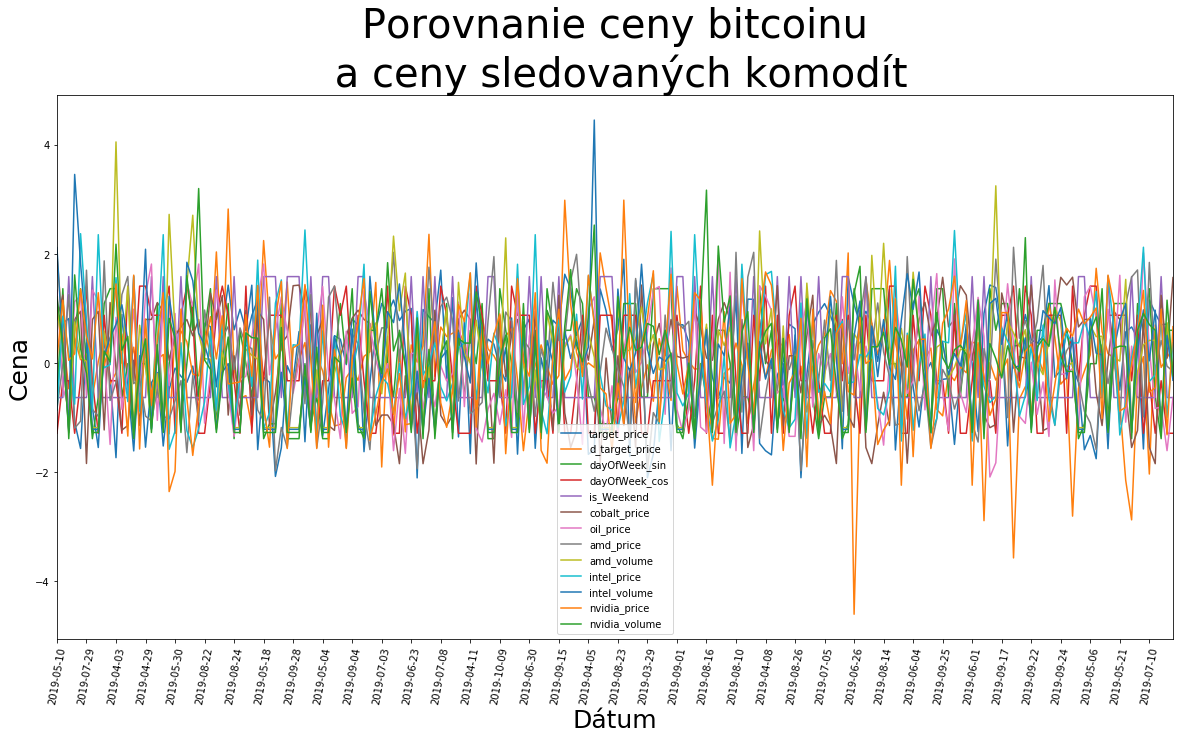

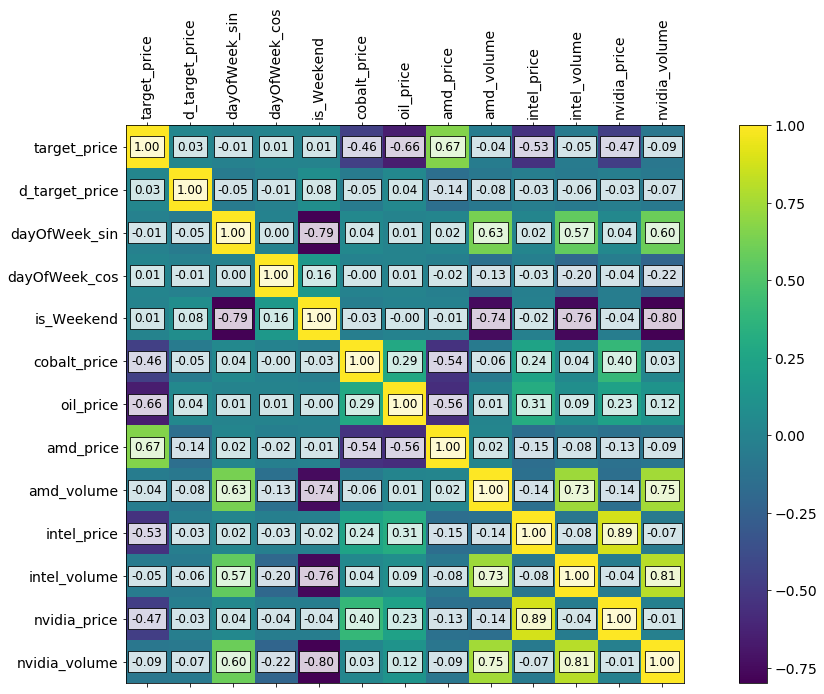

In [234]:
dfc = PlotColumn(dff, ['target_price','d_target_price', 'dayOfWeek_sin', 'dayOfWeek_cos', 'is_Weekend', 'cobalt_price', 'oil_price', 'amd_price' , 'amd_volume','intel_price','intel_volume','nvidia_price','nvidia_volume'], scaler = StandardScaler(), title ='Porovnanie ceny bitcoinu\n a ceny sledovaných komodít',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc, fontsize = 12)
print("Durbin-Watson test for avg_clheaders_compound autocorrelation:  " + str(AutocorrelationTest(dfc.target_price)))
print("Durbin-Watson test for cobalt_price autocorrelation:  " + str(AutocorrelationTest(dfc.cobalt_price)))
print("Durbin-Watson test for oil_price autocorrelation:  " + str(AutocorrelationTest(dfc.oil_price)))
print("Durbin-Watson test for amd_price autocorrelation:  " + str(AutocorrelationTest(dfc.amd_price)))
print("Durbin-Watson test for amd_volume autocorrelation:  " + str(AutocorrelationTest(dfc.amd_volume)))
print("Durbin-Watson test for intel_price autocorrelation:  " + str(AutocorrelationTest(dfc.intel_price)))
print("Durbin-Watson test for nvidia_price autocorrelation:  " + str(AutocorrelationTest(dfc.nvidia_price)))
print("Durbin-Watson test for nvidia_volume autocorrelation:  " + str(AutocorrelationTest(dfc.nvidia_volume)))
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

Durbin-Watson test for avg_clheaders_compound autocorrelation:  1.9167553055294673
Durbin-Watson test for avg_clheaders_compound autocorrelation:  2.0347211906884257
Durbin-Watson test for avg_clcontents_compound autocorrelation:  1.858867874740139
Durbin-Watson test for d_avg_clheaders_compound autocorrelation:  1.8419843225025914
Durbin-Watson test for avg_clheaders_compound autocorrelation:  2.0766237410736608
Durbin-Watson test for avg_clheaders_compound autocorrelation:  2.1790940377764465
Durbin-Watson test for avg_clcontents_compound autocorrelation:  1.9688448014822633
Durbin-Watson test for d_avg_clheaders_compound autocorrelation:  2.1306419856504375
<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation


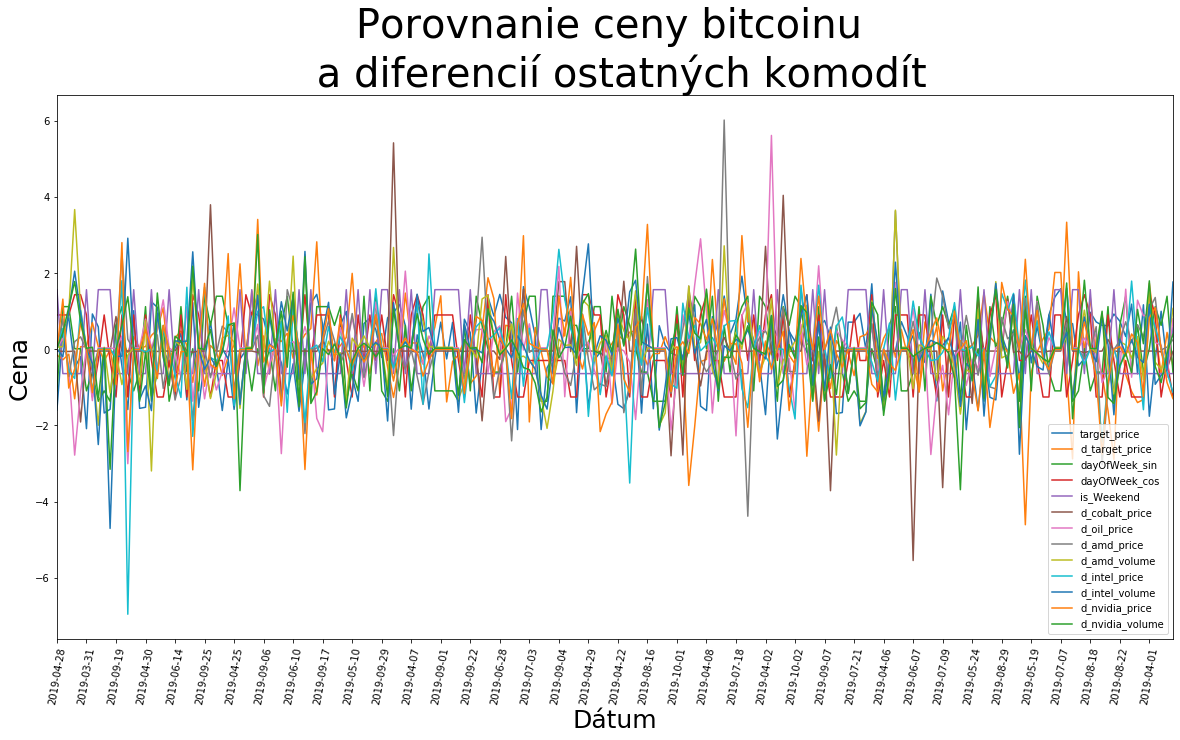

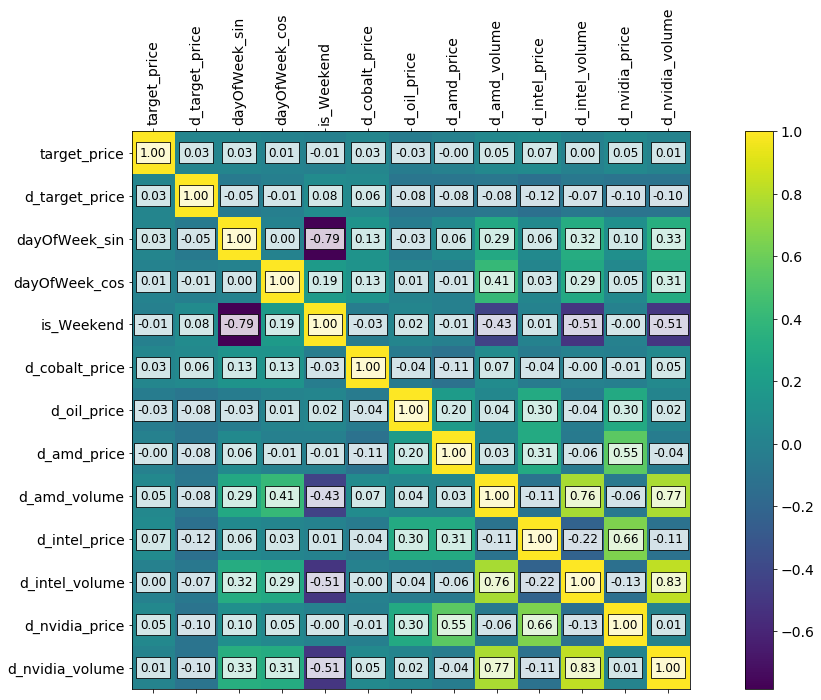

In [267]:
dfc = PlotColumn(dff, ['target_price','d_target_price', 'dayOfWeek_sin', 'dayOfWeek_cos', 'is_Weekend', 'd_cobalt_price', 'd_oil_price', 'd_amd_price' , 'd_amd_volume','d_intel_price','d_intel_volume','d_nvidia_price','d_nvidia_volume'], scaler = StandardScaler(), title ='Porovnanie ceny bitcoinu \n a diferencií ostatných komodít',  ylabel = 'Cena', xlabel = 'Dátum')
PlotCorrelationMatrix(dfc, fontsize = 12)
print("Durbin-Watson test for avg_clheaders_compound autocorrelation:  " + str(AutocorrelationTest(dfc.target_price)))
print("Durbin-Watson test for avg_clheaders_compound autocorrelation:  " + str(AutocorrelationTest(dfc.d_cobalt_price)))
print("Durbin-Watson test for avg_clcontents_compound autocorrelation:  " + str(AutocorrelationTest(dfc.d_oil_price)))
print("Durbin-Watson test for d_avg_clheaders_compound autocorrelation:  " + str(AutocorrelationTest(dfc.d_amd_price)))
print("Durbin-Watson test for avg_clheaders_compound autocorrelation:  " + str(AutocorrelationTest(dfc.d_amd_volume)))
print("Durbin-Watson test for avg_clheaders_compound autocorrelation:  " + str(AutocorrelationTest(dfc.d_intel_price)))
print("Durbin-Watson test for avg_clcontents_compound autocorrelation:  " + str(AutocorrelationTest(dfc.d_nvidia_price)))
print("Durbin-Watson test for d_avg_clheaders_compound autocorrelation:  " + str(AutocorrelationTest(dfc.d_nvidia_volume)))
print("<0,2) - positive correlation ; (2,4> - negative correlation; 2 - no correlation")

# Classification SECTION

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC  
 - SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto_deprecated’, coef0=0.0, shrinking=True, probability=False, tol=0.001,    cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)  
 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier  
 - RandomForestClassifier(n_estimators=’warn’, criterion=’gini’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None)
 
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB
 - GaussianNB(priors=None, var_smoothing=1e-09)
 
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier  
 - KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’, metric_params=None, n_jobs=None, **kwargs)


In [235]:
def PrepareDataset():
    df = pd.read_csv("data.csv")
    dff = df[['date', 'close_price', 'dayOfWeek_sin', 'dayOfWeek_cos', 'is_Weekend', 'cobalt_price', 'oil_price', 'amd_price' , 'amd_volume','intel_price','intel_volume','nvidia_price','nvidia_volume']].copy()
    dff['target_price'] = dff['close_price'].shift(-1)
    dff['d_target_price'] = np.append(np.diff(dff['close_price']), 0)
    #dff['d_price_move'] = dff.close_price - dff.open_price
    dff['d_cobalt_price'] = np.insert(np.diff(dff['cobalt_price']), 0, 0)
    dff['d_oil_price'] = np.insert(np.diff(dff['oil_price']), 0, 0)
    dff['d_amd_price'] = np.insert(np.diff(dff['amd_price']), 0, 0)
    dff['d_amd_volume'] = np.insert(np.diff(dff['amd_volume']), 0, 0)
    dff['d_intel_price'] = np.insert(np.diff(dff['intel_price']), 0, 0)
    dff['d_intel_volume'] = np.insert(np.diff(dff['intel_volume']), 0, 0)
    dff['d_nvidia_price'] = np.insert(np.diff(dff['nvidia_price']), 0, 0)
    dff['d_nvidia_volume'] = np.insert(np.diff(dff['nvidia_volume']), 0, 0)
    
    dff = dff[:-1]
    dff = dff.iloc[1:]
    dff['target_rise_fall'] = (dff.d_target_price>0.0)
    return dff

def GetColumnSet(choice = None):
    if choice == 'compound':
        ret = ['target_rise_fall','dayOfWeek_sin', 'dayOfWeek_cos', 'is_Weekend', 'cobalt_price', 'oil_price', 'amd_price','intel_price','nvidia_price']
        msg = ret
    if choice is None:
        ret = None
        msg = 'ALL'
    print("Selected columns>> " + str(msg)+"\n\n")
    return ret

# Random Forrest whole set

In [237]:
###CLASSIFICATION###DONT MOVE PrepareDataset()  TO SEPARATE BLOCK  - DF must be initialized every time

dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler(), classifier = RandomForestClassifier(n_estimators=101), columns = GetColumnSet('compound'))
feature_importances = pd.DataFrame(clf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(10)

Selected columns>> ['target_rise_fall', 'dayOfWeek_sin', 'dayOfWeek_cos', 'is_Weekend', 'cobalt_price', 'oil_price', 'amd_price', 'intel_price', 'nvidia_price']


(197, 24)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.53      0.33      0.41        27
        True       0.42      0.62      0.50        21

    accuracy                           0.46        48
   macro avg       0.47      0.48      0.45        48
weighted avg       0.48      0.46      0.45        48

----------------Confusion_matrix--------------
[[ 9 18]
 [ 8 13]]
--------------------Accuracy------------------
0.4583333333333333


importance
amd_price        0.184704
oil_price        0.166134
nvidia_price     0.155466
intel_price      0.151348
cobalt_price     0.141749
dayOfWeek_sin    0.101693
dayOfWeek_cos    0.078545
is_Weekend       0.020360

# GaussianNB - whole dataset

In [239]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK 
dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler() , classifier = GaussianNB(), columns = GetColumnSet('compound'))

Selected columns>> ['target_rise_fall', 'dayOfWeek_sin', 'dayOfWeek_cos', 'is_Weekend', 'cobalt_price', 'oil_price', 'amd_price', 'intel_price', 'nvidia_price']


(197, 24)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.41      0.37      0.39        19
        True       0.61      0.66      0.63        29

    accuracy                           0.54        48
   macro avg       0.51      0.51      0.51        48
weighted avg       0.53      0.54      0.54        48

----------------Confusion_matrix--------------
[[ 7 12]
 [10 19]]
--------------------Accuracy------------------
0.5416666666666666


# SVM - whole dataset

Selected columns>> ['target_rise_fall', 'dayOfWeek_sin', 'dayOfWeek_cos', 'is_Weekend', 'cobalt_price', 'oil_price', 'amd_price', 'intel_price', 'nvidia_price']


(197, 24)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.41      0.33      0.37        21
        True       0.55      0.63      0.59        27

    accuracy                           0.50        48
   macro avg       0.48      0.48      0.48        48
weighted avg       0.49      0.50      0.49        48

----------------Confusion_matrix--------------
[[ 7 14]
 [10 17]]
--------------------Accuracy------------------
0.5


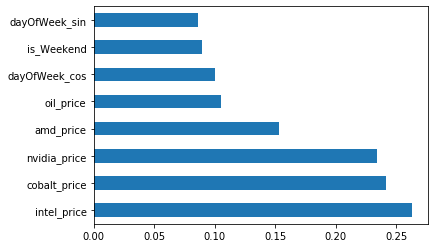

In [241]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK |
dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler(), classifier = svm.LinearSVC(), columns = GetColumnSet('compound'))
pd.Series(abs(clf.coef_[0]), index=X_train.columns).nlargest(20).plot(kind='barh')

In [247]:
###CLASSIFICATION###DONT MOVE THIS SECTION TO SEPARATE BLOCK |
dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler(), classifier = svm.SVC(gamma='scale'), columns = GetColumnSet('compound'))

Selected columns>> ['target_rise_fall', 'dayOfWeek_sin', 'dayOfWeek_cos', 'is_Weekend', 'cobalt_price', 'oil_price', 'amd_price', 'intel_price', 'nvidia_price']


(197, 24)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.57      0.52      0.55        23
        True       0.59      0.64      0.62        25

    accuracy                           0.58        48
   macro avg       0.58      0.58      0.58        48
weighted avg       0.58      0.58      0.58        48

----------------Confusion_matrix--------------
[[12 11]
 [ 9 16]]
--------------------Accuracy------------------
0.5833333333333334



# KNeighborsClassifier - whole dataset

In [254]:
dff = PrepareDataset()
dff = shuffle(dff)
clf, X_train = Predict(dff,scaler = StandardScaler() , classifier = KNeighborsClassifier(n_neighbors=5), columns = GetColumnSet('compound'))

Selected columns>> ['target_rise_fall', 'dayOfWeek_sin', 'dayOfWeek_cos', 'is_Weekend', 'cobalt_price', 'oil_price', 'amd_price', 'intel_price', 'nvidia_price']


(197, 24)
---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.40      0.38      0.39        21
        True       0.54      0.56      0.55        27

    accuracy                           0.48        48
   macro avg       0.47      0.47      0.47        48
weighted avg       0.48      0.48      0.48        48

----------------Confusion_matrix--------------
[[ 8 13]
 [12 15]]
--------------------Accuracy------------------
0.4791666666666667


# Try for Votting classifiers

In [255]:
def Voting(df, columns = None, scaler = StandardScaler()):
    print(df.shape)
    df.drop(df.tail(7).index,inplace=True) #missing data from news
    
    if columns is None:
        df = df.drop(['date','target_price', 'd_target_price'], axis = 1) # delete non-numeric columns
    else:
        target = df['target_rise_fall']
        df = df[columns].copy()
        df['target_rise_fall'] = target
        
    X = df.loc[:, df.columns != 'target_rise_fall']
    y = df.loc[:, df.columns == 'target_rise_fall']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    X_train_r = X_train.copy()
    if scaler is not None:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    gnb = GaussianNB()
    rf = RandomForestClassifier(n_estimators=101)
    svml = svm.LinearSVC()
    svc = svm.SVC(gamma='scale')
    knb = KNeighborsClassifier(n_neighbors=5)
    
    gnb.fit(X_train, y_train.values.ravel())
    gnb_predict = gnb.predict(X_test)
    
    rf.fit(X_train, y_train.values.ravel())
    rf_predict = rf.predict(X_test)
    
    svml.fit(X_train, y_train.values.ravel())
    svm_predict = svml.predict(X_test)
    
    svc.fit(X_train, y_train.values.ravel())
    svc_predict = svc.predict(X_test)
    
    knb.fit(X_train, y_train.values.ravel())
    knb_predict = knb.predict(X_test)
    
    res = pd.DataFrame(gnb_predict, columns = ['gnb_predict']) 
    res['rf_predict'] = rf_predict
    res['svm_predict'] = svm_predict
    res['svc_predict'] = svc_predict
    res['knb_predict'] = knb_predict
    
    res['tftarget'] = np.array(y_test)
    return res

In [261]:
dff = PrepareDataset()
dff = shuffle(dff)
res = Voting(dff, columns = GetColumnSet(), scaler = StandardScaler())

Selected columns>> ALL


(197, 24)


C:\Users\kriza\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [262]:
res.head(5)

gnb_predict  rf_predict  svm_predict  svc_predict  knb_predict  tftarget
0        False       False        False        False        False     False
1         True        True         True         True         True      True
2        False       False         True        False        False     False
3         True       False        False        False         True      True
4        False        True         True         True         True      True

In [263]:
for index, row in res.iterrows():
    count = 0
    if row['gnb_predict'] == True:
        count +=1
    if row['rf_predict'] == True:
        count +=1
    if row['svm_predict'] == True:
        count +=1
    if row['svc_predict'] == True:
        count +=1
    if row['knb_predict'] == True:
        count +=1
    if count >=3:
        res.set_value(index, 'vote_res', True)
        count = 0
        continue
    res.set_value(index, 'vote_res', False)
    count = 0
    

C:\Users\kriza\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\kriza\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [264]:
res.head(50)

gnb_predict  rf_predict  svm_predict  svc_predict  knb_predict  tftarget  \
0         False       False        False        False        False     False   
1          True        True         True         True         True      True   
2         False       False         True        False        False     False   
3          True       False        False        False         True      True   
4         False        True         True         True         True      True   
5          True        True         True         True         True     False   
6          True        True         True         True         True      True   
7          True        True         True         True         True     False   
8         False       False        False         True         True      True   
9          True       False        False        False        False      True   
10         True       False         True        False        False      True   
11         True        True         True         True         True     False   
12         True        True        False         True         True      True   
13         True       False         True         True         True      True   
14         True        True         True        False         True      True   
15        False       False        False        False        False     False   
16         True       False        False        False         True      True   
17         True       False        False         True         True     False   
18         True        True         True         True         True      True   
19        False       False         True        False        False     False   
20         True       False         True         True         True     False   
21         True        True        False        False        False     False   
22         True       False        False        False        False     False   
23         True       False         True        False         True      True   
24        False       False        False         True         True      True   
25        False       False        False        False        False     False   
26         True        True         True         True         True      True   
27         True        True         True        False         True      True   
28         True        True        False        False         True      True   
29         True       False        False        False        False      True   
30        False       False        False        False        False      True   
31         True       False        False        False        False      True   
32         True        True         True         True         True      True   
33         True        True         True         True        False      True   
34        False       False        False        False         True     False   
35        False        True         True         True         True      True   
36         True       False        False        False        False     False   
37        False       False        False        False        False      True   
38         True        True         True         True         True      True   
39         True        True         True        False        False     False   
40        False       False        False        False         True     False   
41        False       False        False        False        False     False   
42        False        True         True         True        False      True   
43        False       False        False        False        False     False   
44         True       False        False        False        False      True   
45         True       False        False         True         True     False   
46         True       False        False        False        False      True   
47         True        True         True         True         True      True   

   vote_res  
0     False  
1      True  
2     False  
3     False  
4      True  

In [265]:

print("---------------------Summary------------------")
print(classification_report(res.tftarget.values.tolist(), res.vote_res.values.tolist()))
print("----------------Confusion_matrix--------------")
print(confusion_matrix(res.tftarget.values.tolist(), res.vote_res.values.tolist()))
print("--------------------Accuracy------------------")
print(accuracy_score(res.tftarget.values.tolist(), res.vote_res.values.tolist()))

---------------------Summary------------------
              precision    recall  f1-score   support

       False       0.50      0.63      0.56        19
        True       0.71      0.59      0.64        29

    accuracy                           0.60        48
   macro avg       0.60      0.61      0.60        48
weighted avg       0.63      0.60      0.61        48

----------------Confusion_matrix--------------
[[12  7]
 [12 17]]
--------------------Accuracy------------------
0.6041666666666666
